# NMF Topic Models

Topic modelling aims to automatically discover the hidden thematic structure in a large corpus of text documents. One approach for topic modelling is to apply *matrix factorisation* methods, such as *Non-negative Matrix Factorisation (NMF)*. In this notebook we look at how to apply NMF using the *scikit-learn* library in Python.

### Applying NMF

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("cenario2-tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 266214 X 12137 document-term matrix


The key input parameter to NMF is the number of topics to generate *k*. For the moment, we will pre-specify a guessed value, for demonstration purposes.

In [2]:
k = 10

Another choice for NMF revolves around initialisation. Most commonly, NMF involves using random initialisation to populate the values in the factors W and H. Depending on the random seed that you use, you may get different results on the same dataset. Instead, using SVD-based initialisation provides more reliable results.

In [3]:
# create the model
from sklearn import decomposition

model = decomposition.NMF(init="nndsvd", n_components=k)

# apply the model and extract the two factor matrices
W = model.fit_transform(A)
H = model.components_

### Examining the Output

NMF produces to factor matrices as its output: *W* and *H*.

The *W* factor contains the document membership weights relative to each of the *k* topics. Each row corresponds to a single document, and each column correspond to a topic.

In [4]:
W.shape

(266214, 10)

For instance, for the first document, we see that it is strongly associated with one topic. However,  each document can be potentially associated with multiple topics to different degrees.

In [5]:
# round to 2 decimal places for display purposes
W[0,:].round(2)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

The *H* factor contains the term weights relative to each of the *k* topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

In [6]:
H.shape

(10, 12137)

For instance, for the term "brexit", we see that it is strongly associated with a single topic. Again, in some cases each term can be associated with multiple topics.

In [7]:
term_index = terms.index('mulher')

# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ])

### Topic Descriptors

The top ranked terms from the *H* factor for each topic can give us an insight into the content of that topic. This is often called the *topic descriptor*. Let's define a function that extracts the descriptor for a specified topic: 

In [8]:
import numpy as np


def get_descriptor(terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
    return top_terms

We can now get a descriptor for each topic using the top ranked terms (e.g. top 10):

In [9]:
descriptors = []

for topic_index in range(k):
    descriptors.append(get_descriptor(terms, H, topic_index, 10))
    str_descriptor = ", ".join(descriptors[topic_index])
    print("Topic %02d: %s" % (topic_index + 1, str_descriptor))

Topic 01: dia, feliz, falte, cada, ninguna, buen, algun, celebrar, dejen, dias
Topic 02: mujeres, mundo, hombres, vida, violencia, historia, ninas, trabajo, pais, mexico
Topic 03: todas, mundo, felicidades, aquellas, especial, luchan, voz, companeras, juntas, abrazo
Topic 04: hoy, dias, siempre, dia, manana, ano, voz, conmemora, nunca, conmemoramos
Topic 05: mujer, internacional, dia, marzo, trabajadora, conmemoracion, conmemora, hombre, vida, sociedad
Topic 06: ser, puede, debe, mujer, ninguna, falte, deberia, vida, hecho, parte
Topic 07: lucha, feminista, derechos, sigue, conmemora, viva, continua, conmemoramos, celebra, marzo
Topic 08: gracias, muchas, ultimo, disponible, siempre, tan, ustedes, mejor, gran, amo
Topic 09: miedo, asi, quiero, queremos, libres, solo, vivas, feminismo, nunca, marcha
Topic 10: igualdad, derechos, genero, violencia, respeto, oportunidades, sociedad, luchando, justicia, real


The rankings above do not show the strength of association for the different terms. We can represent the distribution of the weights for the top terms in a topic using a *matplotlib* horizontal bar chart.

In [10]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

Define a function to create a bar chart for the specified topic, based on the *H* factor from the current NMF model:

In [11]:
def plot_top_term_weights(terms, H, topic_index, top):
    
    # get the top terms and their weights
    top_indices = np.argsort(H[topic_index, :])[::-1]
    top_terms = []
    top_weights = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
        top_weights.append(H[topic_index, term_index])
    
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    
    # create the plot
    fig = plt.figure(figsize=(13, 8))
    
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(
        ypos, top_weights, align="center", color="green", tick_label=top_terms
    )
    plt.xlabel("Term Weight", fontsize=14)
    plt.tight_layout()
    plt.show()

So for instance, for the 7th topic we can generate a plot with the top 15 terms using:

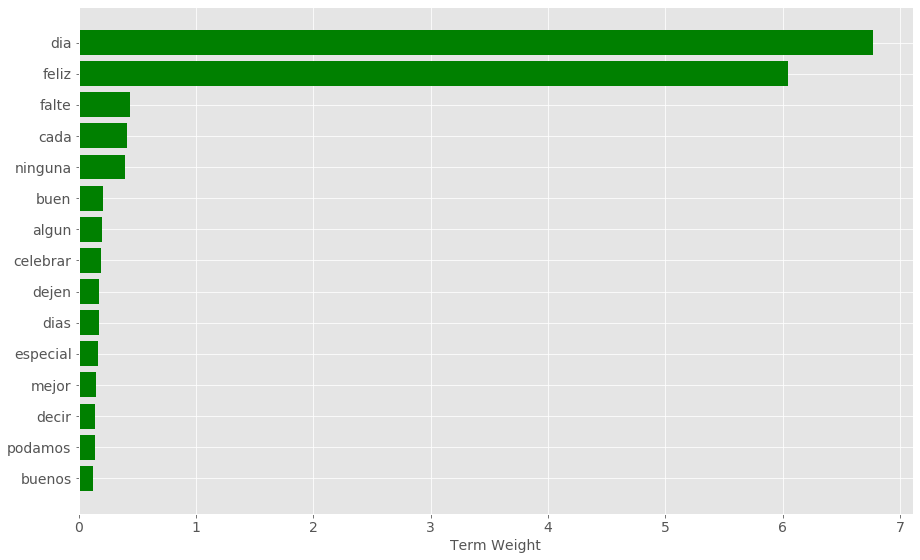

In [12]:
plot_top_term_weights( terms, H, 0, 15 )

### Most Relevant Documents

We can also look at the snippets for the top-ranked documents for each topic. We'll define a function to produce this ranking also.

In [13]:
def get_top_snippets(all_snippets, W, topic_index, top):
    
    # reverse sort the values to sort the indices
    top_indices = np.argsort(W[:, topic_index])[::-1]
    
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    
    for doc_index in top_indices[0:top]:
        top_snippets.append(all_snippets[doc_index])
    
    return top_snippets

For instance, for the first topic listed above, the top 10 documents are:

In [14]:
topic_snippets = get_top_snippets(snippets, W, 0, 10)

for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ((i + 1), snippet))

01. dia feliz dia feliz dia feliz dia feliz dia feliz dia feliz dia feliz dia feliz dia feliz dia feliz 
02. feliz dia bizcochas
03. feliz dia karatekas
04. feliz dia xicas
05. feliz dia xoxos
06. buah feliz dia
07. feliz dia pili
08. feliz dia xaguzar
09. mayu feliz dia
10. feliz dia pagues glosa


Similarly, for the second topic:

In [15]:
topic_snippets = get_top_snippets(snippets, W, 1, 10)

for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ((i + 1), snippet))

01. mujeres imperfectas
02. mujeres mujeres
03. visibilice compense mujeres
04. mujeres funandome
05. mujeres darwin bioprospecting
06. mujeres perdicion
07. mujeres humedales
08. iconicas mujeres
09. viceministerios representados mujeres
10. narc0s mujeres


### Exporting the Results

If we want to keep this topic model for later user, we can save it using *joblib*:

In [16]:
joblib.dump((W,H,terms,snippets), "cenario2-tweets-model-nmf-k%02d.pkl" % k) 

['cenario2-tweets-model-nmf-k10.pkl']